# Mapping Heavy Commute Flows in California (LODES OD Data)

This notebook filters and maps heavy commute flows using LODES origin-destination data for California (2022).

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point, LineString
import random
import numpy as np


## Load LODES OD Data

In [2]:
# Load the dataset
df = pd.read_csv("ca_od_aux_JT00_2022.csv.gz")
df.head()


,w_geocode,h_geocode,S000,SA01,SA02,SA03,SE01,SE02,SE03,SI01,SI02,SI03,createdate
0,60014001002015,484510001002015,1,0,1,0,0,0,1,0,0,1,20240920
1,60014001002016,221030411053011,1,1,0,0,0,0,1,0,0,1,20240920
2,60014002002006,250173104003007,1,0,1,0,0,1,0,0,0,1,20240920
3,60014003001008,511076118082008,1,0,1,0,0,0,1,0,0,1,20240920
4,60014003002003,320339701001666,1,0,1,0,0,1,0,0,0,1,20240920


## Filter for Heavy Commute Flows

In [3]:
# Filter for OD pairs with S000 ≥ 10
threshold = 10
heavy_flows = df[df["S000"] >= threshold].copy()
heavy_flows["h_prefix"] = heavy_flows["h_geocode"].astype(str).str[:12]
heavy_flows["w_prefix"] = heavy_flows["w_geocode"].astype(str).str[:12]
heavy_flows = heavy_flows.groupby(["h_prefix", "w_prefix"]).agg({"S000": "sum"}).reset_index()
heavy_flows.head()


,h_prefix,w_prefix,S000
0,360610002024,603726790230,11
1,360610015012,603726790230,12
2,360610155011,603726790230,15
3,360610181005,603726790230,10


## Simulate Coordinates for Visualization

In [4]:
# Simulate lat/lon for each unique geocode
def random_latlon(center_lat, center_lon, spread=0.5):
    return center_lat + random.uniform(-spread, spread), center_lon + random.uniform(-spread, spread)

unique_geos = pd.unique(heavy_flows[['h_prefix', 'w_prefix']].values.ravel())
geo_locs = {g: random_latlon(36.5, -119, spread=1.5) for g in unique_geos}

# Add lat/lon to heavy_flows
heavy_flows["h_lat"] = heavy_flows["h_prefix"].map(lambda g: geo_locs[g][0])
heavy_flows["h_lon"] = heavy_flows["h_prefix"].map(lambda g: geo_locs[g][1])
heavy_flows["w_lat"] = heavy_flows["w_prefix"].map(lambda g: geo_locs[g][0])
heavy_flows["w_lon"] = heavy_flows["w_prefix"].map(lambda g: geo_locs[g][1])
heavy_flows.head()


,h_prefix,w_prefix,S000,h_lat,h_lon,w_lat,w_lon
0,360610002024,603726790230,11,37.499549,-119.804439,37.722878,-118.199595
1,360610015012,603726790230,12,36.687994,-119.870527,37.722878,-118.199595
2,360610155011,603726790230,15,36.779877,-118.863540,37.722878,-118.199595
3,360610181005,603726790230,10,35.913190,-119.690120,37.722878,-118.199595


## Create Line Geometry from Home to Work

In [5]:
# Create lines for each OD pair
geometry = [LineString([(row.h_lon, row.h_lat), (row.w_lon, row.w_lat)]) for _, row in heavy_flows.iterrows()]
gdf = gpd.GeoDataFrame(heavy_flows, geometry=geometry, crs="EPSG:4326")
gdf.head()


,h_prefix,w_prefix,S000,h_lat,h_lon,w_lat,w_lon,geometry
0,360610002024,603726790230,11,37.499549,-119.804439,37.722878,-118.199595,"LINESTRING (-119.80444 37.49955, -118.19959 37..."
1,360610015012,603726790230,12,36.687994,-119.870527,37.722878,-118.199595,"LINESTRING (-119.87053 36.68799, -118.19959 37..."
2,360610155011,603726790230,15,36.779877,-118.863540,37.722878,-118.199595,"LINESTRING (-118.86354 36.77988, -118.19959 37..."
3,360610181005,603726790230,10,35.913190,-119.690120,37.722878,-118.199595,"LINESTRING (-119.69012 35.91319, -118.19959 37..."


## Commute Flows

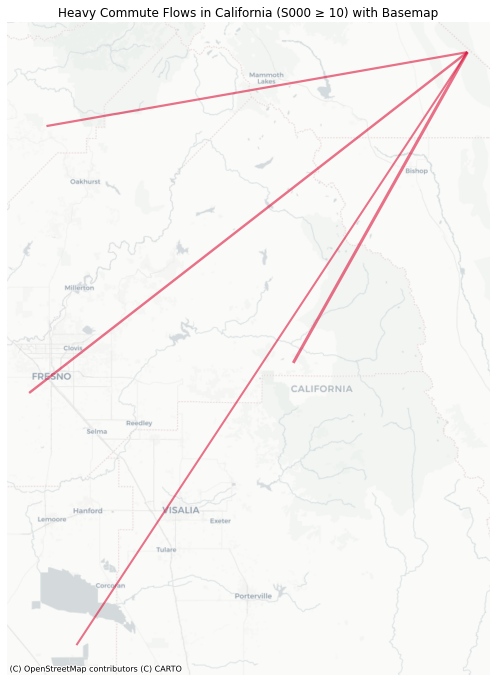

In [6]:
import contextily as ctx

# Convert to Web Mercator
gdf_web = gdf.to_crs(epsg=3857)

fig, ax = plt.subplots(figsize=(12, 12))
gdf_web.plot(ax=ax, linewidth=gdf_web["S000"] / 5, alpha=0.6, color="crimson")
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)
plt.title("Heavy Commute Flows in California (S000 ≥ 10) with Basemap")
plt.axis("off")
plt.show()
